### Import Libraries

In [6]:
import os
import sys
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import seaborn as sns

### Exploratory Data Analysis - Metadata

In [11]:
data = pd.read_csv('dataset/metadata.csv')
print(f'Shape of Metadata information: {data.shape}')
data.head()

Shape of Metadata information: (6572, 6)


,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


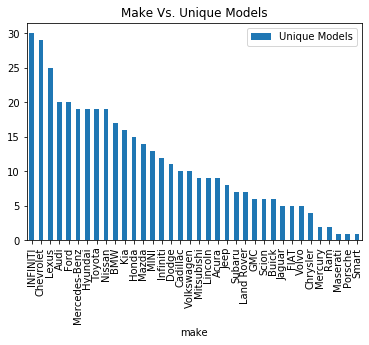

In [12]:
df1 = data.groupby(['make']).model.nunique().to_frame('Unique Models').\
            sort_values(['Unique Models'],ascending=False).reset_index()
plt.show(df1.plot.bar(x='make',y='Unique Models',rot=90, title='Make Vs. Unique Models'))

Shape of data with all information: (6572, 6)
Shape of data after removing Null values in "year" column: (6561, 6)


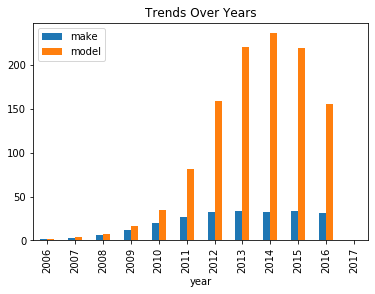

In [13]:
print(f'Shape of data with all information: {data.shape}')
df2 = data[data['year'].isnull()==False]
print(f'Shape of data after removing Null values in "year" column: {df2.shape}')

df2 = df2.astype({'year':'int'})
df2 = df2.groupby(['year'])['make','model'].nunique().reset_index().set_index('year')

plt.show(df2.plot.bar(title='Trends Over Years'))

### Understanding Image Data
#### Count of Train and Test data

In [14]:
TRAIN_PATH = 'dataset/train/'
TEST_PATH = 'dataset/test/'

try:
    train_ids = next(os.walk(TRAIN_PATH))[2]
    test_ids = next(os.walk(TEST_PATH))[2]
except Exception as e:
    print("Error in getting training and testing filenames")
    print(e)
    
print(train_ids[:3],'\n')

print(f'Count of images in Train data {len(train_ids)}')
print(f'Count of images in Test data {len(test_ids)}')

['bd8d5780ed04_07.jpg', '6752de44b721_01.jpg', '1390696b70b6_02.jpg'] 

Count of images in Train data 5088
Count of images in Test data 100064


#### Sample Image And Its Mask

Type of image: <class 'numpy.ndarray'> and Shape of image: (1280, 1918, 3)


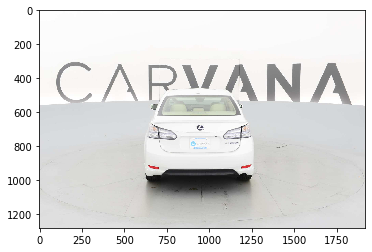

In [15]:
img1 = plt.imread('dataset/train/151c7f2d4183_09.jpg')

print(f'Type of image: {type(img1)} and Shape of image: {img1.shape}')
plt.imshow(img1)

Type of image: <class 'numpy.ndarray'> and Shape of image: (1280, 1918, 4)


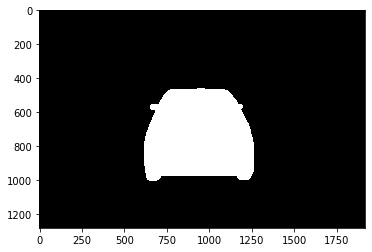

In [16]:
img1 = plt.imread('dataset/train_masks/151c7f2d4183_09_mask.gif')

print(f'Type of image: {type(img1)} and Shape of image: {img1.shape}')
plt.imshow(img1)

### Pre-Processing
#### Image Settings

In [17]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

IMG_WIDTH_BIG = 480
IMG_HEIGHT_BIG = 320

IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/train/'
TEST_PATH = 'dataset/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Resize Images And Create X_train, Y_train And X_test

In [80]:
# Create X_train
X_train = np.zeros((len(train_ids), IMG_HEIGHT_BIG, IMG_WIDTH_BIG, IMG_CHANNELS), dtype=np.uint8)

if not os.path.isfile('resizedXTrainBIG.npy'):
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        img = imread(TRAIN_PATH + id_)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT_BIG, IMG_WIDTH_BIG), mode='constant', preserve_range=True)
        X_train[n] = img
    np.save('resizedXTrainBIG',X_train)
else:
    print('Using the existing resized images')
    X_train = np.load('resizedXTrainBIG.npy')
    
print("Shape of X_train: "+str(X_train.shape),'\n')


# Create Y_train
Y_train = np.zeros((len(train_ids), IMG_HEIGHT_BIG, IMG_WIDTH_BIG, 1), dtype=np.uint8)

if not os.path.isfile('resizedYTrainBIG.npy'):
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        img = imread('dataset/train_masks/' + id_[:-4] + '_mask.gif')
#       imread takes the image as 1 channel, but plt.imread takes it as 4 channels
#       img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = resize(img, (IMG_HEIGHT_BIG, IMG_WIDTH_BIG), mode='constant', preserve_range=True)
        Y_train[n] = img.reshape(IMG_HEIGHT_BIG, IMG_WIDTH_BIG , 1)
    np.save('resizedYTrainBIG',Y_train)
else:
    print('Using the existing resized images')
    Y_train = np.load('resizedYTrainBIG.npy')

print("Shape of Y_train: "+str(Y_train.shape))

# Create X_test
# X_test = np.zeros((len(test_ids), IMG_HEIGHT_BIG, IMG_WIDTH_BIG, IMG_CHANNELS), dtype=np.uint8)

# if not os.path.isfile('resizedXTestBIG.npy'):
#     for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#         img = imread(TEST_PATH + id_)[:,:,:IMG_CHANNELS]
#         img = resize(img, (IMG_HEIGHT_BIG, IMG_WIDTH_BIG), mode='constant', preserve_range=True)
#         X_test[n] = img
#     np.save('resizedXTestBIG',X_test)
# else:
#     print('Using the existing resized images')
#     X_test = np.load('resizedXTestBIG.npy')
    
# print("Shape of X_test: "+str(X_test.shape))

Using the existing resized images
Shape of X_train: (5088, 320, 480, 3) 

Using the existing resized images
Shape of Y_train: (5088, 320, 480, 1)


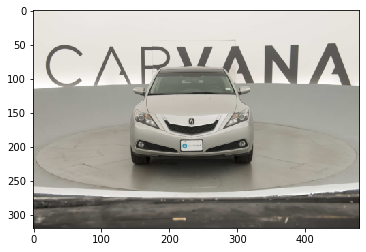

In [81]:
plt.imshow(X_train[12])

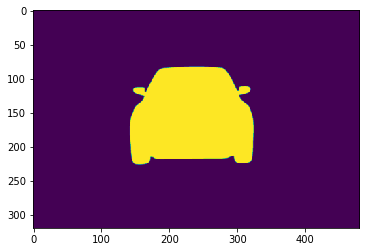

In [82]:
plt.imshow(Y_train[12].reshape(320,480))

### Separate Validation data from Train data

In [83]:
nImages = X_train.shape[0]
valImages = int(0.2*nImages)
print(f'Images in Train {nImages-valImages} and Images in Val {valImages}','\n')

indices = np.random.permutation(nImages)
val_idx,train_idx = indices[:valImages], indices[valImages:]

X_train, X_val = X_train[train_idx,:,:,:,], X_train[val_idx,:,:,:,]
Y_train, Y_val = Y_train[train_idx,:,:,:,], Y_train[val_idx,:,:,:,]

print(f'X_train {X_train.shape} | Y_train {Y_train.shape}')
print(f'X_val   {X_val.shape} | Y_val   {Y_val.shape}')

Images in Train 4071 and Images in Val 1017 

X_train (4071, 320, 480, 3) | Y_train (4071, 320, 480, 1)
X_val   (1017, 320, 480, 3) | Y_val   (1017, 320, 480, 1)


### Data Augmentation On Train Data

In [111]:
import albumentations as albu

augments_list = [albu.VerticalFlip(p=1),
                 albu.VerticalFlip(p=1),
                 # albu.RandomRotate90(p=1),albu.HorizontalFlip(p=1),
                 # albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
                 albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                 albu.GridDistortion(p=1),
                ]

In [112]:
# Augmenting only 1000 images out of 4071 training images

import random

X_train_aug = X_train
Y_train_aug = Y_train
 
augment_indices = []
augment_applied = []

for i in np.random.randint(low=0,high=X_train.shape[0],size=1000):
    
    # Select a random data point for augmentation
    img,mask = X_train[i] ,Y_train[i]
    
    # Implement a random augmentation on selected data point
    rand_aug = random.choice(augments_list)
    augmented = rand_aug(image=img, mask=mask)
    
    image_auged = augmented['image']
    mask_auged = augmented['mask']
    X_train_aug[i,:,:,:] = image_auged
    Y_train_aug[i,:,:,:] = mask_auged

    augment_indices.append(i)
    augment_applied.append(rand_aug)

print(f'X_train_aug {X_train_aug.shape} | Y_train_aug {Y_train_aug.shape}')

X_train_aug (4071, 320, 480, 3) | Y_train_aug (4071, 320, 480, 1)


#### Check On Augmented Images

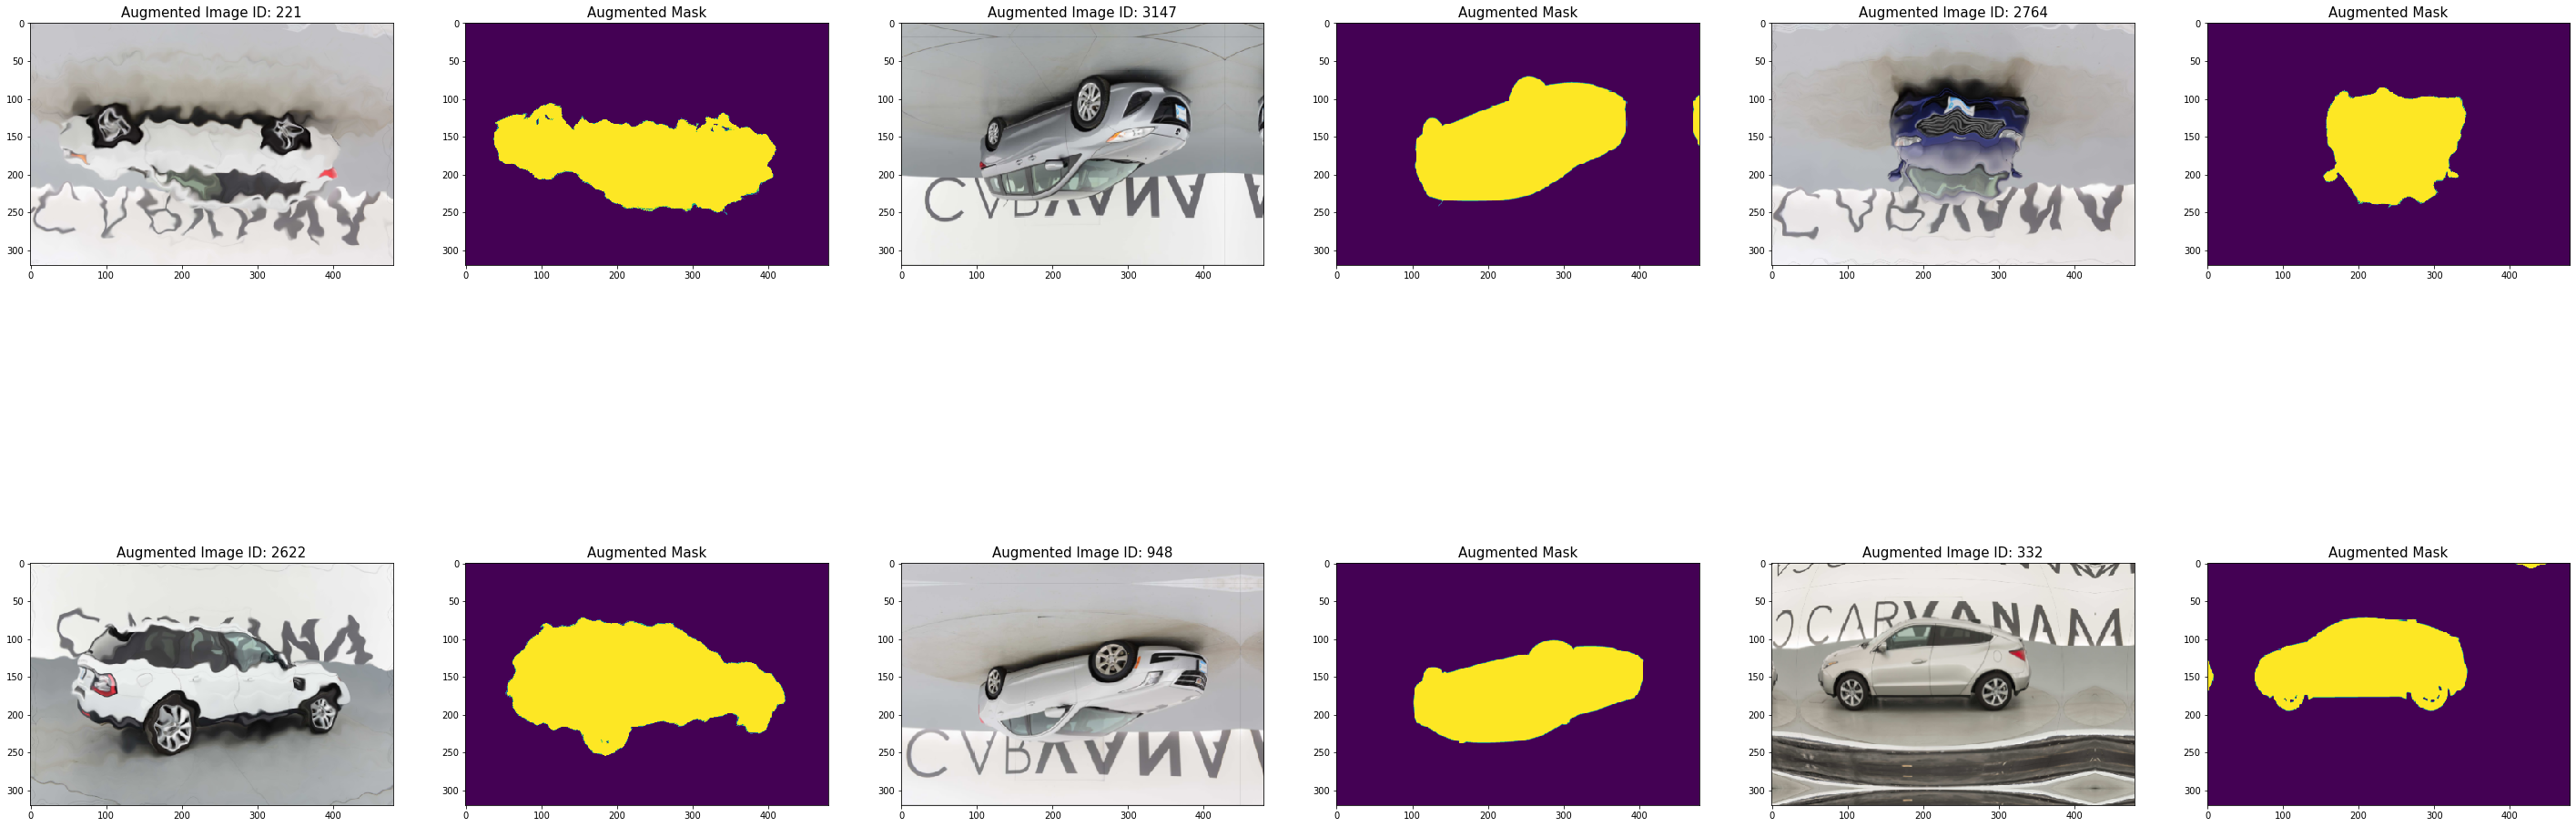

In [113]:
fig = plt.figure(figsize=(50,20)) 
nSamples = 6
nrows = 2
ncols = 6

ids = np.random.choice(augment_indices, nSamples, replace=False)
counter = 1

for i in ids: 
    plt.subplot(nrows, ncols, counter)
    plt.imshow(X_train_aug[i])
    plt.title('Augmented Image ' + 'ID: '+str(i), fontsize=15)
    counter += 1
    
    plt.subplot(nrows, ncols, counter)
    plt.imshow(Y_train_aug[i].reshape(320,480))
    plt.title('Augmented Mask', fontsize=15)
    counter += 1

### Train A Model With U-Net Architecture

In [114]:
# Replacing with the augmented images

X_train = X_train_aug
Y_train = Y_train_aug

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t,tf.int32)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2) # here 3 refers to the number of classes
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def mean_iou(y_true, y_pred):
    prec = []
    y_pred_ = tf.cast(y_pred > 0.5,tf.int32)
    score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [143]:
inputs = Input((IMG_HEIGHT_BIG, IMG_WIDTH_BIG, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 320, 480, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 320, 480, 16) 448         lambda_11[0][0]                  
__________________________________________________________________________________________________
dropout_91 (Dropout)            (None, 320, 480, 16) 0           conv2d_191[0][0]                 
___________________________________________________________________________________________

In [139]:
print(X_train.shape)
print(Y_train.shape)

(4071, 320, 480, 3)
(4071, 320, 480, 1)


In [144]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-unet-v4.h5', verbose=1, save_best_only=True)
results = model.fit((X_train), (Y_train/255.0), validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 3663 samples, validate on 408 samples
Epoch 1/10
3663/3663 [==============================] - 2024s 553ms/step - loss: 0.3564 - binary_accuracy: 0.7257 - mean_iou: 0.4725 - val_loss: 0.2354 - val_binary_accuracy: 0.7557 - val_mean_iou: 0.4544

Epoch 00001: val_loss improved from inf to 0.23537, saving model to model-unet-v4.h5
Epoch 2/10
3663/3663 [==============================] - 2035s 555ms/step - loss: 0.1473 - binary_accuracy: 0.7362 - mean_iou: 0.4419 - val_loss: 0.1096 - val_binary_accuracy: 0.7601 - val_mean_iou: 0.4322

Epoch 00002: val_loss improved from 0.23537 to 0.10955, saving model to model-unet-v4.h5
Epoch 3/10
3663/3663 [==============================] - 2024s 553ms/step - loss: 0.0970 - binary_accuracy: 0.7472 - mean_iou: 0.4262 - val_loss: 0.1308 - val_binary_accuracy: 0.7629 - val_mean_iou: 0.4219

Epoch 00003: val_loss did not improve from 0.10955
Epoch 4/10
3663/3663 [==============================] - 2023s 552ms/step - loss: 0.0796 - binary_accuracy: 0.7

### Model Performance

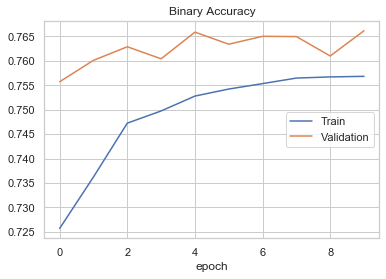

In [460]:
# summarize history for accuracy
plt.plot(results.history['binary_accuracy'])
plt.plot(results.history['val_binary_accuracy'])
plt.title('Binary Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

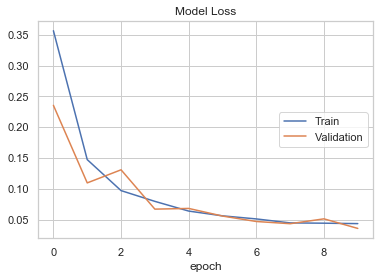

In [461]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

### Predict On Validation Data (not exposed to training)
#### Load The Model Built On Train Data. 

In [156]:
model = load_model('model-unet-v4.h5', custom_objects={'mean_iou': mean_iou})
Y_val_pred = model.predict(X_val, verbose=1)

1017/1017 [==============================] - 112s 110ms/step


#### Visualize Original Images, Original Masks And Predicted Masks Of Validation Data

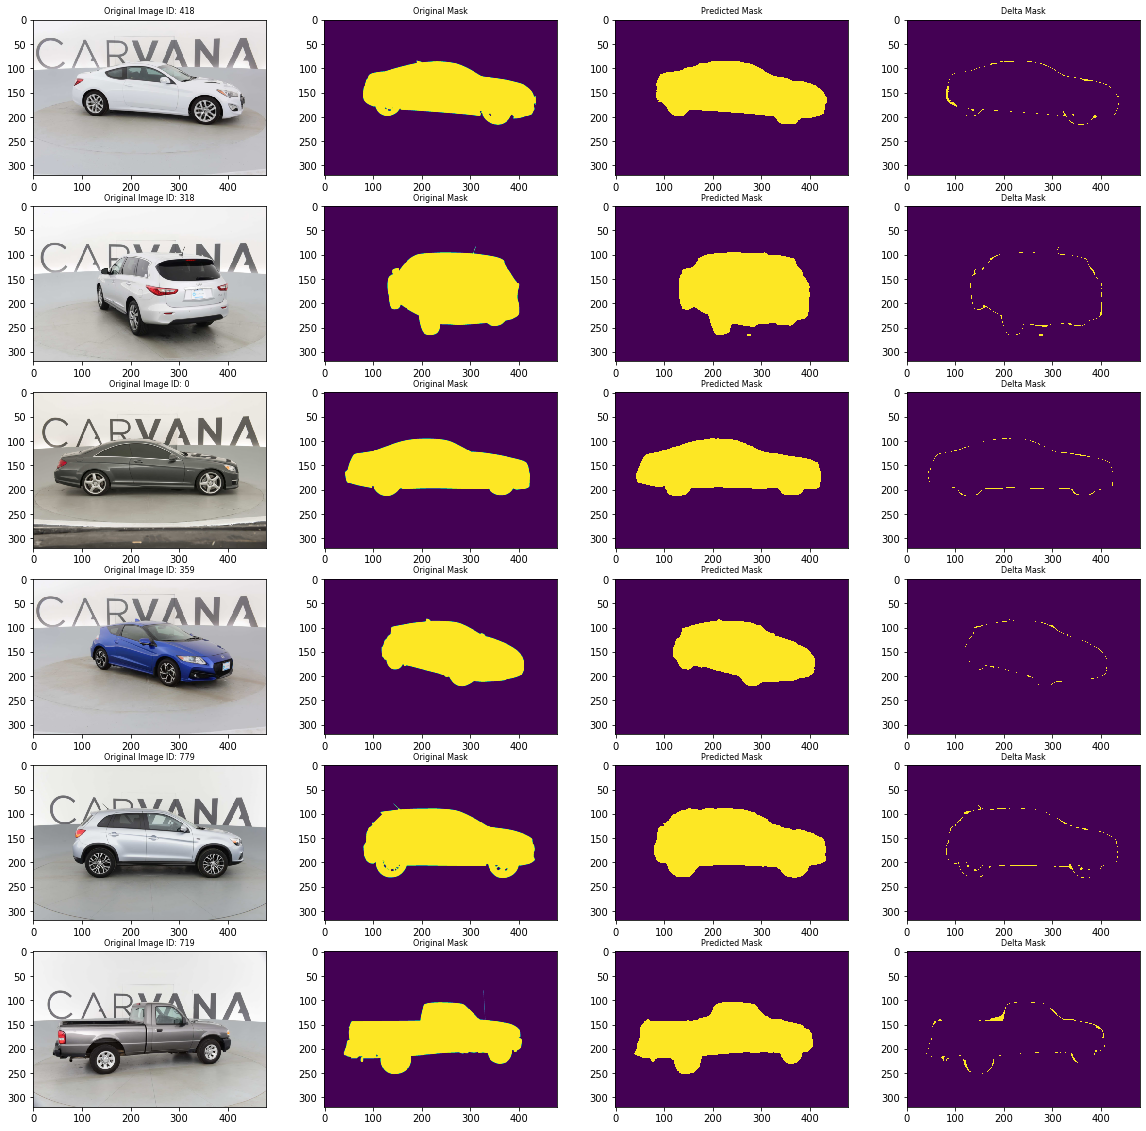

In [398]:
fig = plt.figure(figsize=(20,20)) 
nSamples = 6
nrows = 6
ncols = 4

ids = np.random.choice(range(X_val.shape[0]), nSamples, replace=False)
counter = 1

for i in ids: 
    #training image
    plt.subplot(nrows, ncols, counter)
    plt.imshow(X_val[i])
    plt.title('Original Image ' + 'ID: '+str(i), fontsize=8)
    counter += 1
    
    #original mask
    plt.subplot(nrows, ncols, counter)
    plt.imshow(np.squeeze(Y_val[i]))
    plt.title('Original Mask', fontsize=8)
    counter += 1
    
    #predicted mask
    plt.subplot(nrows, ncols, counter)
    plt.imshow(np.squeeze(Y_val_pred[i]>0.5))
    plt.title('Predicted Mask', fontsize=8)
    counter += 1

    #delta mask
    plt.subplot(nrows, ncols, counter)
    delta = np.squeeze(np.abs(np.rint(Y_val[i]/255) - np.rint(Y_val_pred[i]>0.5)))
    plt.imshow(delta)
    plt.title('Delta Mask', fontsize=8)
    counter += 1

### Test Images Without Background

In [160]:
def actual_img_masked(actual_img, predicted_mask, threshold=0.01):
    predicted_mask = predicted_mask.reshape(320,480)
    predicted_mask = np.array(predicted_mask>threshold).astype(np.int)
    img_masked = np.zeros_like(actual_img)
    
    for i in range(actual_img.shape[2]):
        img_masked[:,:,i] = (actual_img[:,:,i].reshape(320,480))*(predicted_mask)
    
    # For a yellow background
    img_masked[:,:,0] = np.where(img_masked[:,:,0]==0, 255, img_masked[:,:,0])
    img_masked[:,:,1] = np.where(img_masked[:,:,1]==0, 255, img_masked[:,:,1])
    return(img_masked)

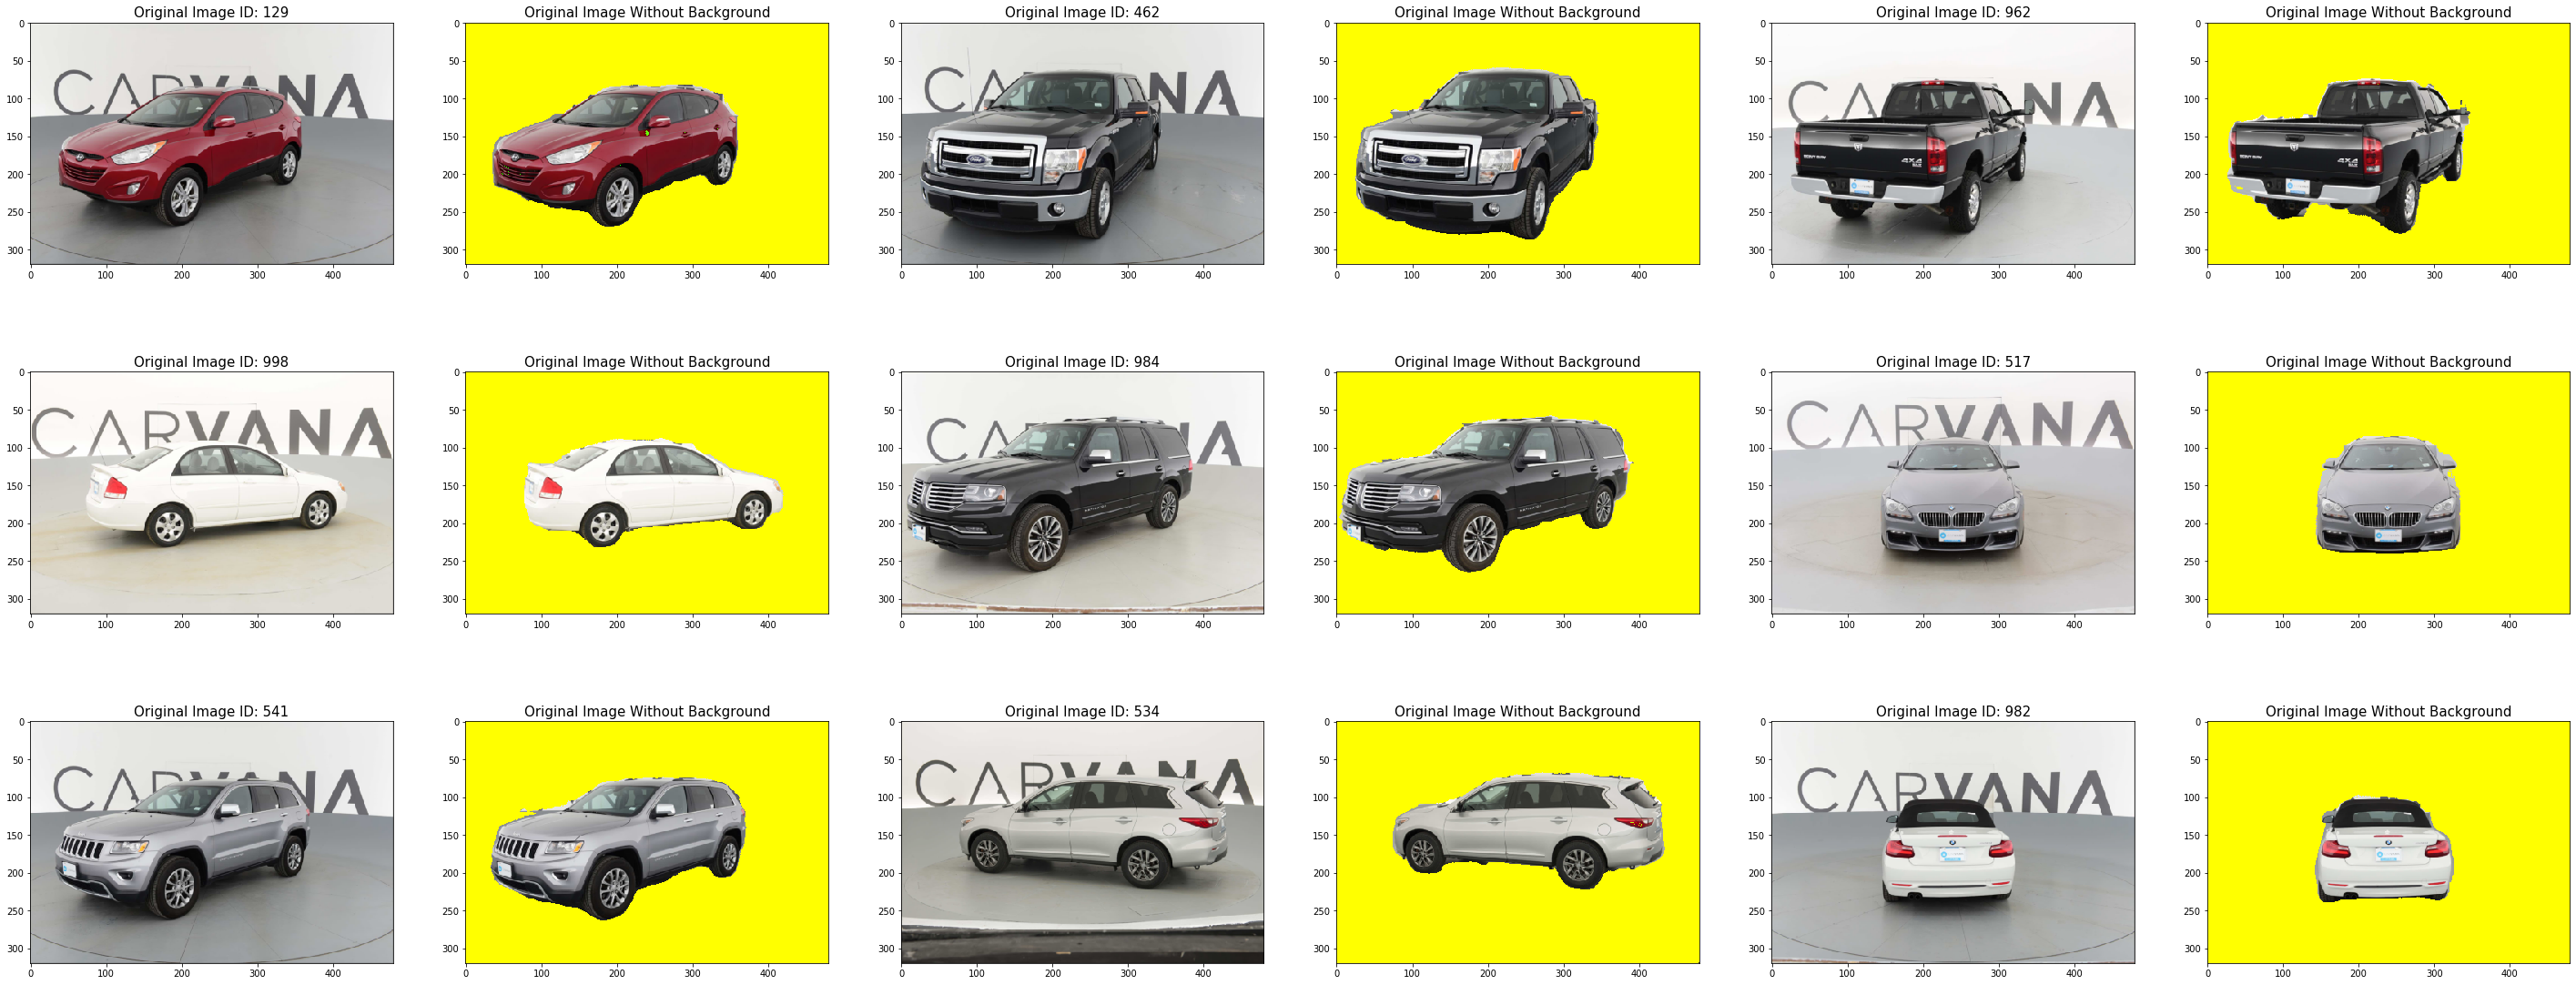

In [164]:
fig = plt.figure(figsize=(50,20)) 
nSamples = 9
nrows = 3
ncols = 6

ids = np.random.choice(range(X_val.shape[0]), nSamples, replace=False)
counter = 1

for i in ids: 
    plt.subplot(nrows, ncols, counter)
    plt.imshow(X_val[i])
    plt.title('Original Image ' + 'ID: '+str(i), fontsize=15)
    counter += 1
    
    plt.subplot(nrows, ncols, counter)
    img_without_backg = actual_img_masked(X_val[i], Y_val_pred[i], threshold=0.5)
    plt.imshow(img_without_backg)
    plt.title('Original Image Without Background', fontsize=15)
    counter += 1

### Quality Assessment

#### IoU / Jaccard Similarity


 Best threshold: 0.5 and Best IoU: 0.972


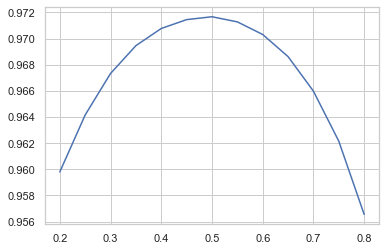

In [450]:
y_true = np.rint(Y_val/255)

threshold_arr = np.arange(0.2,0.8,0.05)
iou_arr = np.zeros(threshold_arr.shape)

for j,i in enumerate(threshold_arr):
    y_pred = np.rint(Y_val_pred>i)

    intersection = np.sum((y_true * y_pred), axis=(1,2,3))
    union = np.sum(y_true,(1,2,3)) + np.sum(y_pred,(1,2,3)) - intersection
    iou = np.mean((intersection+1) / (union+1), axis=0)
    iou_arr[j] = iou
    
print(f'\n Best threshold: {round(threshold_arr[np.argmax(iou_arr)],2)} and Best IoU: {round(np.max(iou_arr),3)}')
plt.plot(threshold_arr, iou_arr)

#### F1 Score / Dice Coefficient


 Best threshold: 0.5 and Best F1 Score: 0.986


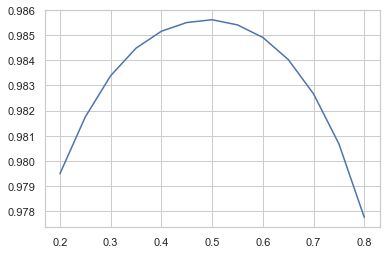

In [462]:
y_true = np.rint(Y_val/255)

threshold_arr = np.arange(0.2,0.8,0.05)
dice_arr = np.zeros(threshold_arr.shape)

for j,i in enumerate(threshold_arr):
    y_pred = np.rint(Y_val_pred>i)

    intersection = np.sum((y_true * y_pred), axis=(1,2,3))
    union = np.sum(y_true,(1,2,3)) + np.sum(y_pred,(1,2,3)) 
    dice = np.mean((2*(intersection+1)) / (union+1), axis=0)
    dice_arr[j] = dice
    
print(f'\n Best threshold: {round(threshold_arr[np.argmax(dice_arr)],2)} and Best F1 Score: {round(np.max(dice_arr),3)}')
plt.plot(threshold_arr, dice_arr)

#### Precision And Recall

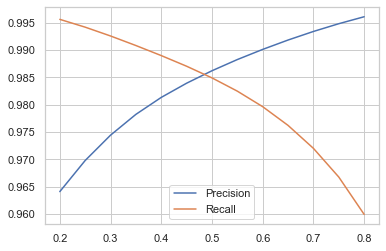

In [458]:
y_true = np.rint(Y_val/255)

threshold_arr = np.arange(0.2,0.8,0.05)
precision_arr = np.zeros(threshold_arr.shape)
recall_arr = np.zeros(threshold_arr.shape)

for j,i in enumerate(threshold_arr):
    y_pred = np.rint(Y_val_pred>i)

    # Statistics for ALL datapoint
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    precision_arr[j] = precision
    recall_arr[j] = recall
    
plt.plot(threshold_arr, precision_arr, label="Precision")
plt.plot(threshold_arr, recall_arr, label="Recall")
plt.legend()

#### Box-Plot of IoU And Dice Coefficient

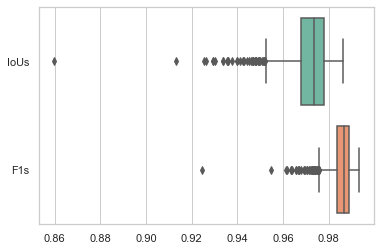

In [459]:
y_true = np.rint(Y_val/255)

# From the above statistics, we confirm that 0.5 is the ideal threshold. So we use this for our final prediction
y_pred = np.rint(Y_val_pred>0.5)

# Statistics for EACH datapoint

# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
TP = np.sum(np.logical_and(y_pred == 1, y_true == 1),axis=(1,2,3))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(y_pred == 0, y_true == 0),axis=(1,2,3))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(y_pred == 1, y_true == 0),axis=(1,2,3))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(y_pred == 0, y_true == 1),axis=(1,2,3))

IoUs = TP/(TP+FP+FN)
F1s = 2*TP/(2*TP+FP+FN)
scores = pd.DataFrame({'IoUs':IoUs,'F1s':F1s})

ax = sns.boxplot(data=scores, orient="h", palette="Set2")

### Model Generalization
#### Load The Model Built On Train Data. 

In [22]:
model = load_model('model-unet-v4.h5', custom_objects={'mean_iou': mean_iou})

In [23]:
def predict_external_img(img):
    # load the test image
    test1_img = plt.imread(img)

    # change image settings as required for prediction
    test1_edit = resize(test1_img, (IMG_HEIGHT_BIG, IMG_WIDTH_BIG), mode='constant', preserve_range=True)
    test1_img = resize(test1_img, (IMG_HEIGHT_BIG, IMG_WIDTH_BIG))
    test1_edit = np.expand_dims(test1_edit,axis=0)

    # predict
    test1_pred = model.predict(test1_edit,verbose=1)

    # change prediction settings as required for plotting
    test1_pred = np.squeeze(test1_pred,axis=(0,3))>0.5
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(test1_img)
    plt.subplot(1,2,2)
    plt.imshow(test1_pred)

1/1 [==============================] - 0s 111ms/step


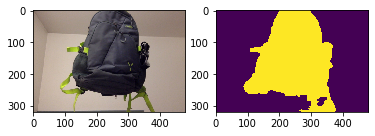

In [25]:
predict_external_img('TestImg2.jpg')

1/1 [==============================] - 0s 115ms/step


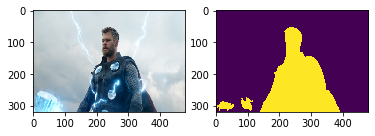

In [26]:
predict_external_img('TestImg3.jpg')

1/1 [==============================] - 0s 133ms/step


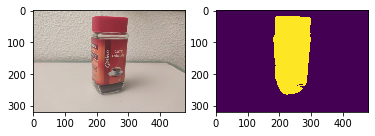

In [27]:
predict_external_img('TestImg5.jpg')